### Introdution

Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA.
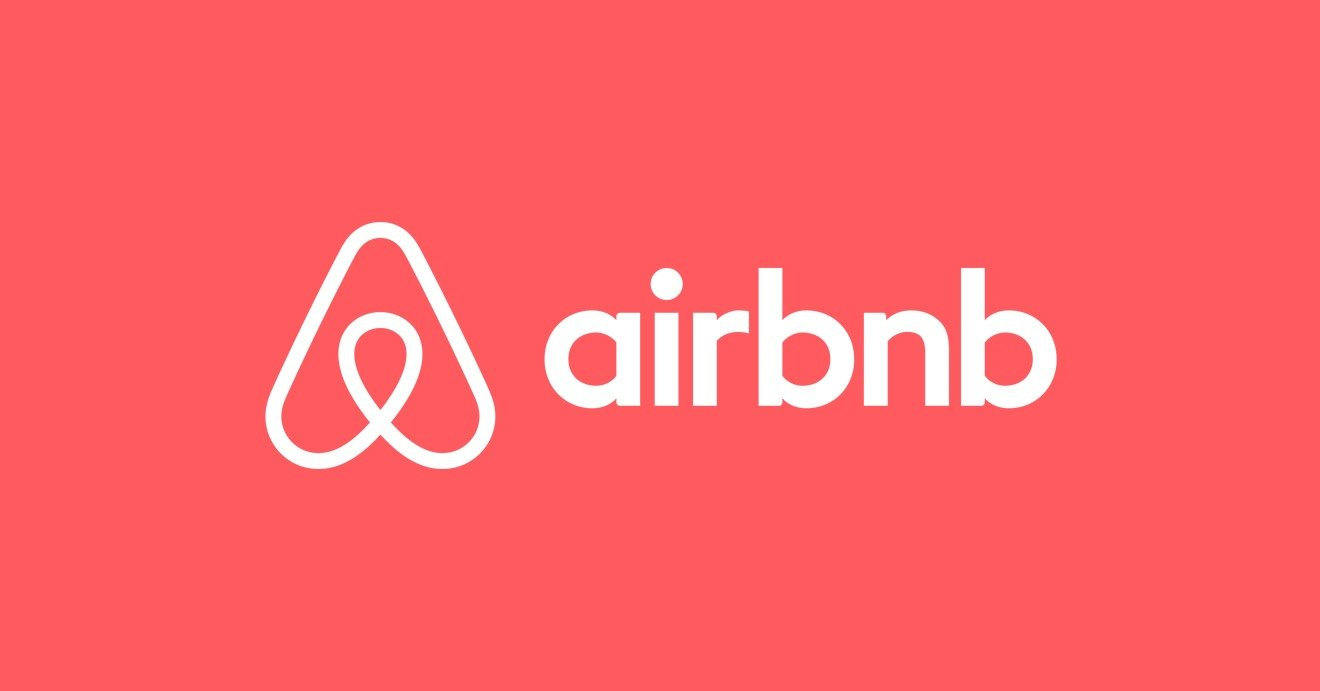

### Useful information

AirBnB reservation price is based on following costs (according to AirBnB official website information https://bit.ly/3c2pCcg):

- Costs determined by the host:
 - Nightly price: Nightly rate decided by the host;
 - Cleaning fee: One-time fee charged by some hosts to cover the cost of cleaning their space;
 - Extra guest fees: One-time fee charged by some hosts to cover other costs related to using their space;
- Costs determined by Airbnb: Airbnb service fee;
- Other costs that may be included: currency exchange fees, VAT, other local taxes etc.

### Questions

- Where prices are usually higher?
- How the price behaves during the year?
- Machine Learning(Feature importances) XGBoost

### Approach

- Data Understanding
- Prepare Data
- Data Modeling
- Evaluate the results

### About the data

The following Airbnb activity is included in this Seattle dataset:

- Listings, including full descriptions and average review score.
- Reviews, including unique id for each reviewer and detailed comments.
- Calendar, including listing id and the price and availability for that day.

In [25]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importing machine learning libraries

from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [26]:
# Importing datasets

calendar_df = pd.read_csv('./calendar.csv')
listing_df = pd.read_csv('./listings.csv')
reviews_df = pd.read_csv('./reviews.csv')

In [27]:
# The first look at the data

calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [28]:
listing_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


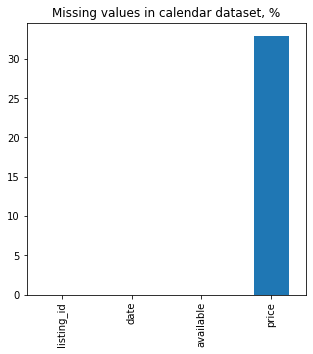

In [29]:
# let's get an overview of the missing values

calendar_missing_values = calendar_df.isnull().mean()*100

calendar_missing_values.plot.bar(title='Missing values in calendar dataset, %', figsize=(5, 5))

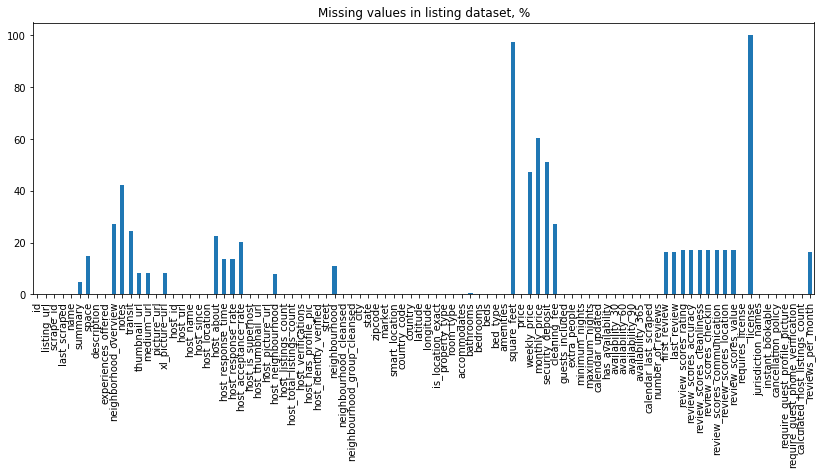

In [30]:
listing_missing_values = listing_df.isnull().mean()*100
listing_missing_values.plot.bar(title='Missing values in listing dataset, %', figsize=(14, 5))

### Data Preparation

Before trying to get the first outcomes, the data should be pre-processed:

- Datasets should be merged into one using the listing identifier;
- Irrelevant columns and columns, which contain missing data should be removed from the analysis;
- Dates and prices should be converted from text into numbers.

In [31]:
# Functions for dataset cleaning

def get_month_from_date(row):
    """Get month from date represented as a string"""
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    """Get year from date represented as a string"""
    return int(row['date'].split('-')[0])

def get_host_since_year(row):
    """Get year from a date represented as a string"""
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

def get_val_from_list(row, column_name, value):
    """Fill in dummy column for values"""
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(df, column_name, max_dummies_num = 10):
    """Split values in columns, which contain lists (for example, amenities)"""
    # Get dictionary of unique values in lists across dataset rows
    values_dict = {}
    
    for unique_value in df[column_name].unique():
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] +1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
    
    # Split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]), axis=1)
        
    return

def get_extra_people_fee(row):
    """Return 1 when the is fee for extra people"""
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0
    
# Main dataset cleaning function

def clean_dataset(listing_df, calendar_df):
    """Input: listing_df - pandas dataframe containing listings data
              calendar_df - pandas dataframe containing calendar data
              
       Output: df - cleaned dataset, which contains merged tables:
               1. irrelevant columns are dropped;
               2. string containing dates are coverted into numbers;
               3. columns, containing lists, are split into several columns;
               4. missing values are imputed with mean or mode;"""
    
    # Merge datasets
    
    listing_df = listing_df.rename(index=str, columns={"id": "listing_id"})
    df = pd.merge(calendar_df, listing_df, on='listing_id')
    
    # Drop the irrelevant columns
    
    columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                  'reviews_per_month']
    df = df.drop(columns = columns_to_drop)
    
    # Convert date from the calendar into month and drop the date column
    
    df['month'] = df.apply(lambda row: get_month_from_date(row), axis=1)
    df['year'] = df.apply(lambda row: get_year_from_date(row), axis=1)
    df = df.drop(columns = ['date'])
    
    # Remove rows where price_x == nan, because price will be used as responde column
    
    df = df.dropna(subset=['price_x'])
    
    # Convert price to number and drop the price_x column
    
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df = df.drop(columns = ['price_x'])
    
    # Convert host_since date into number and fill in missing values, drop the orginal column
    
    df['host_since_year'] = df.apply(lambda row: get_host_since_year(row), axis=1)
    df['host_since_year'].fillna(df['host_since_year'].mean(), inplace=True)
    df = df.drop(columns = ['host_since'])
    
    # Convert host_response_rate into number and fill in missing values, drop the original column
    
    df['host_response_rate_num'] = df['host_response_rate'].astype(str)
    df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
    df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace=True)
    df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')
    df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])
    
    # Fill missing values with mean value for host_listings_count
    
    df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace=True)
    
    # Split host_verifications into dummy columns and drop the original column
    
    split_list_into_columns(df, 'host_verifications')
    df = df.drop(columns = ['host_verifications'])
    
    # Fill in missing values for bathrooms, bredrooms and beds with mode
    
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    
    # Split amenities into dummy columns and drop the original column
    
    split_list_into_columns(df, 'amenities')
    df = df.drop(columns = ['amenities'])
    
    # Turn extra people fee into binary column (1 - if fee for extra people is charged, 0 - otherwise)
    
    df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row), axis=1)
    df = df.drop(columns = ['extra_people'])
    
    # Fill missing values for review scores columns
    
    review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    for column in review_scores_columns:
        df[column].fillna(df[column].mean(), inplace=True)
        
    return df   

In [32]:
# Apply functions above to clean dataset

df = clean_dataset(listing_df, calendar_df)

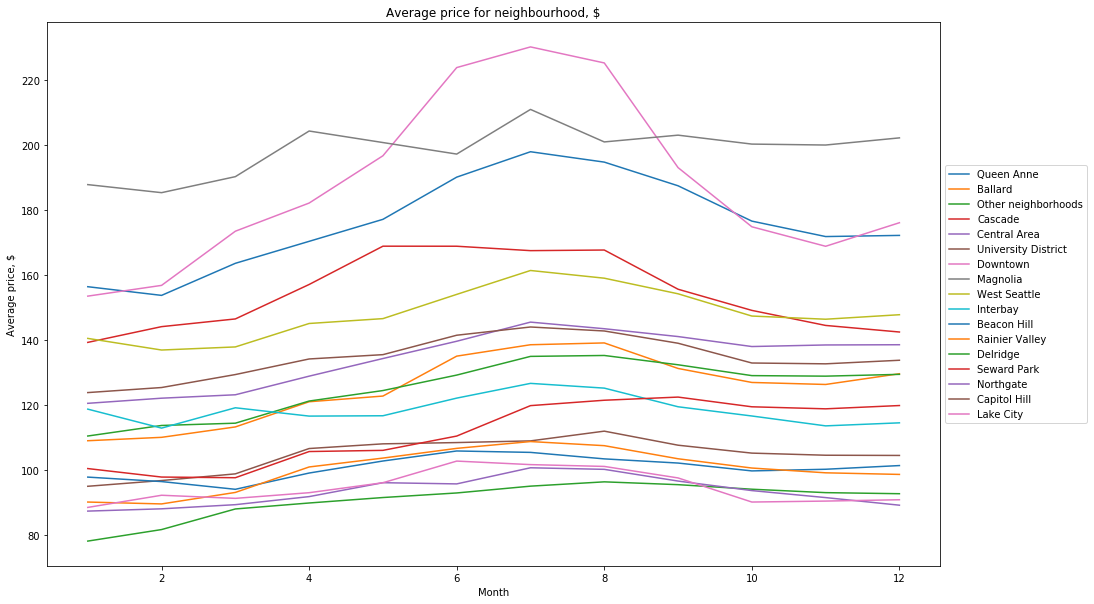

In [33]:
# Where prices are usually higher?

# Get list of neighbourhoods
neighbourhoods = df['neighbourhood_group_cleansed'].unique()

# Get prices by month and neighbourhood
price_by_month_neighbourhood = df.groupby(['month', 'neighbourhood_group_cleansed']).mean().reset_index()

# Plot prices for each neighbourhood

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)

for neighbourhood in neighbourhoods:
    ax.plot(price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['month'],
           price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['price'],
           label = neighbourhood)
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price for neighbourhood, $')

plt.savefig('average price for neighbourhood')

plt.show()

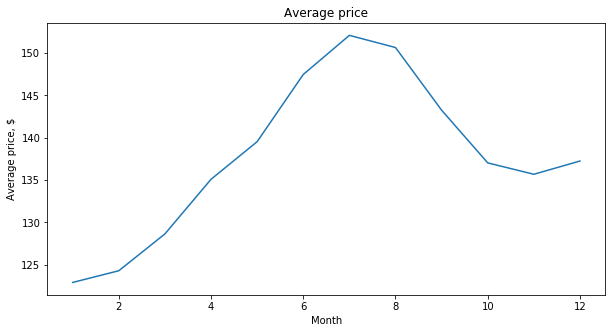

In [34]:
# How the price behaves during the year?

# Find average price by month

average_price_by_month = df.groupby(['month'])['price'].mean()

# Plot

plt.figure(figsize=(10, 5))
plt.plot(average_price_by_month)
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price')

plt.savefig('average price for month')

plt.show()

In [35]:
# Machine Learning(Feature importances) XGBoost

# Turn categorical columns into dummies

cat_columns = list(df.select_dtypes(include=['object']).columns)

for col in cat_columns:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)
    
# Drop listind_id and year columns

df = df.drop(columns = ['listing_id', 'year'])

In [36]:
# Prepare train and test datasets for modeling

TEST_SIZE = 0.3
RAND_STATE = 42

X = df.drop(columns = 'price')
y = df[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RAND_STATE)

In [37]:
# Train XGBoost Regressor model to predict price

xgb = xgboost.XGBRegressor(n_estimators = 100, learning_rate = 0.08, gamma = 0, subsample = 0.075, colsample_bytree = 1, max_depth = 7)
xgb.fit(X_train, y_train)

# Calculate and print scores for the model for top 15 features

y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_preds), mean_squared_error(y_test, y_test_preds)))
print('R^2 train: %.3f, test: %.3f' %(r2_score(y_train, y_train_preds), r2_score(y_test, y_test_preds)))

MSE train: 878.667, test: 885.479
R^2 train: 0.921, test: 0.919


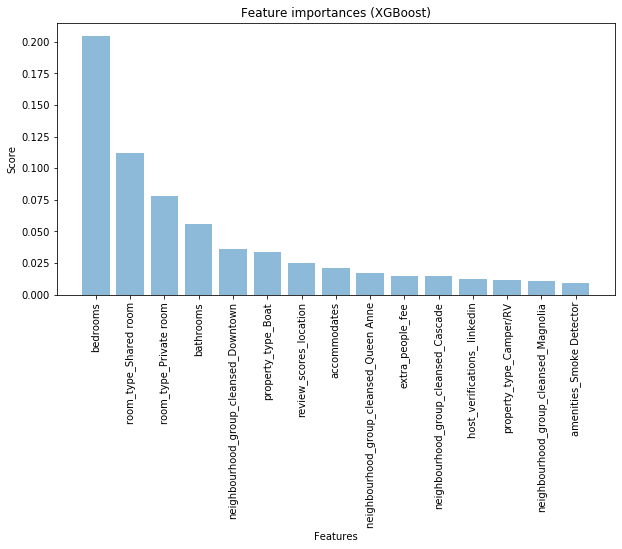

In [39]:
# Get feature importances from the model

headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

# Plot feature importances for top 15 features

features = xgb_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = xgb_feature_importances['score'][:15]

plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (XGBoost)')

plt.savefig('feature importantes XGB')

plt.show()